# Загрузка данных

Загружаю пакеты:

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

# Функция - обрабтное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Загружаю данные из файла, скачанного с Google Analytics:

In [2]:
# Загружаю датасет из своей директории
data = pd.read_csv("https://raw.githubusercontent.com/Quantanomo/data_sets/master/ga_transactions.csv", 
                   na_values="NaN", sep = ';')
data.head()

,date,transactions
0,20190601,12945
1,20190602,13354
2,20190603,22882
3,20190604,23349
4,20190605,22454


Привожу дату в удобный формат:

In [3]:
data.date = pd.to_datetime(data.date, format='%Y%m%d')
data.set_index('date', inplace = True)
data.tail(1)

,transactions
date,
2020-03-31,26232


Данные у меня ограничены мартом 2020. Март я отложу в сторонку и буду проверять на нем качество предсказания. А на остальном фрейме - буду обучать модель.

In [4]:
train = data[:'2020-02']
test = data['2020-03']

Смотрю на данные:

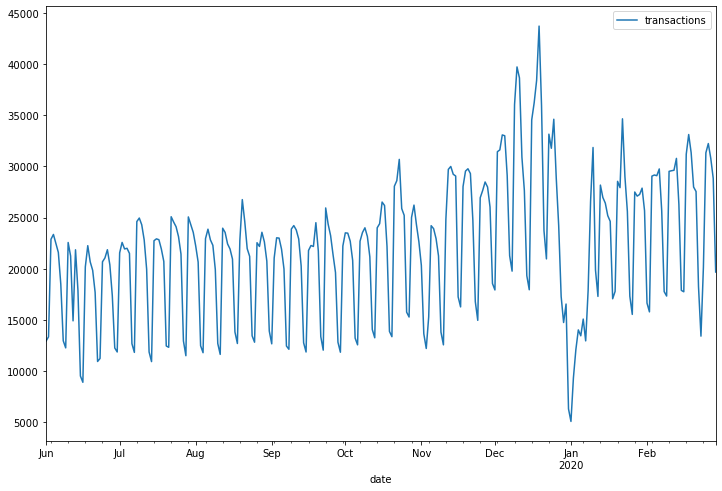

In [5]:
train.plot(figsize = (12,8))

На графике видно, что:
     - Он похож на стационарный
     - Есть недельные колебания (просадка в выходные дни)
     - Есть слабый восходящий тренд
     - Сильные отклонения декабря и января, скорее всего, объясняются праздниками
Проверю временной ряд на стационарность с помощью критерия Дики-Фуллера. В котором тестируется нулевая гипотеза о нестационарности ряда. Уровень значимости будет стандартный - 0.05. И посмотрю на сезонную и трендовую составляющую временного ряда:

Критерий Дики-Фуллера: p=0.108389


<Figure size 864x576 with 0 Axes>

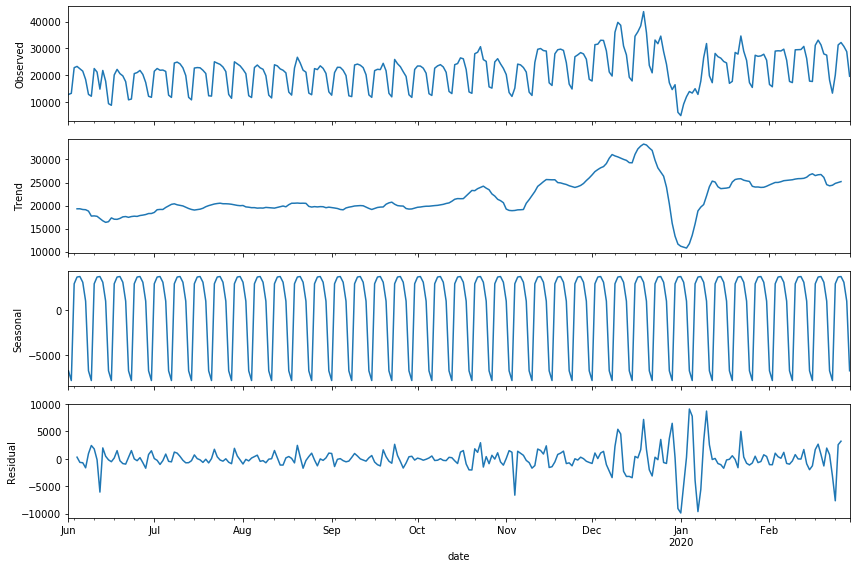

In [6]:
plt.figure(figsize(12,8))
g = sm.tsa.seasonal_decompose(train.transactions).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train.transactions)[1])

Какие выводы можно сделать?
1. Критерий Дики-Фуллера не отвергает нулевую гипотезу о нестационарности ряда. Это не хорошо.
2. На графиках виден тренд, ожидание которого отлично от нуля
3. Ряд имеет ярко выраженную сезонность (недельную)
4. Остатки модели похожи на белый шум (случайное блуждание) - это очень хорошо.

Итак, у нас есть сезонность, тренд и нестационарность. От этого всего нужно избавиться. Сезонность регулируется сезонными параметрами ARIMA, а от тренда буду избавляться с помощью дифференцирования. Но для начала использую еще один трюк - сглаживание дисперсии, который должен положительно сказаться на стационарности. По остаткам модели видно, что в декабре и январе дисперсию сильно расшатало - нужно ее успокоить.

## Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.798654
Критерий Дики-Фуллера: p=0.105928


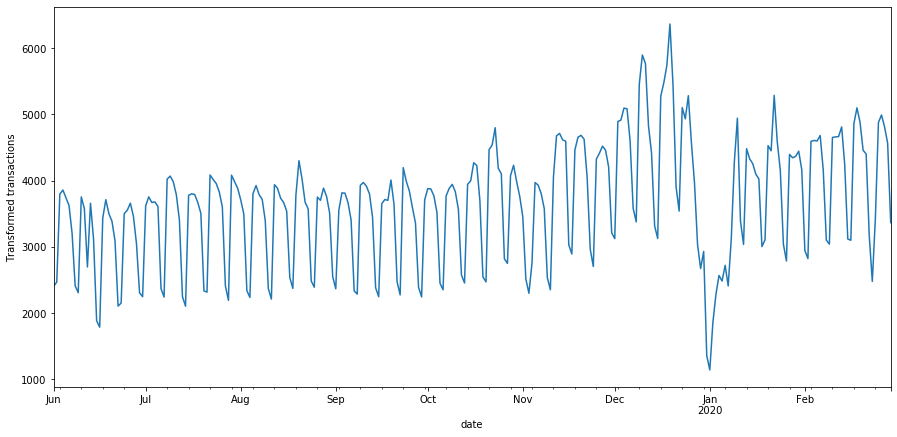

In [7]:
pd.options.mode.chained_assignment = None 

train['transactions_box'], lmbda = stats.boxcox(train.transactions)
plt.figure(figsize(15,7))
train.transactions_box.plot()
plt.ylabel(u'Transformed transactions')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train.transactions_box)[1])

Трюк не сработал - такое бывает)  Критерий Дики-Фуллера не сильно изменился и параметр Бокса-Кокса близок к 1. (коеф = 1, означает исходный ряд). Ну что ж...

## Дифференцирование ряда

Начну с сезонного дифференцирования. В моем случае сезон это 7 дней. Вот от каждого дня я отниму его значение 7 дней назад и посмотрю что из этого получится:

Критерий Дики-Фуллера: p=0.000899


<Figure size 1080x720 with 0 Axes>

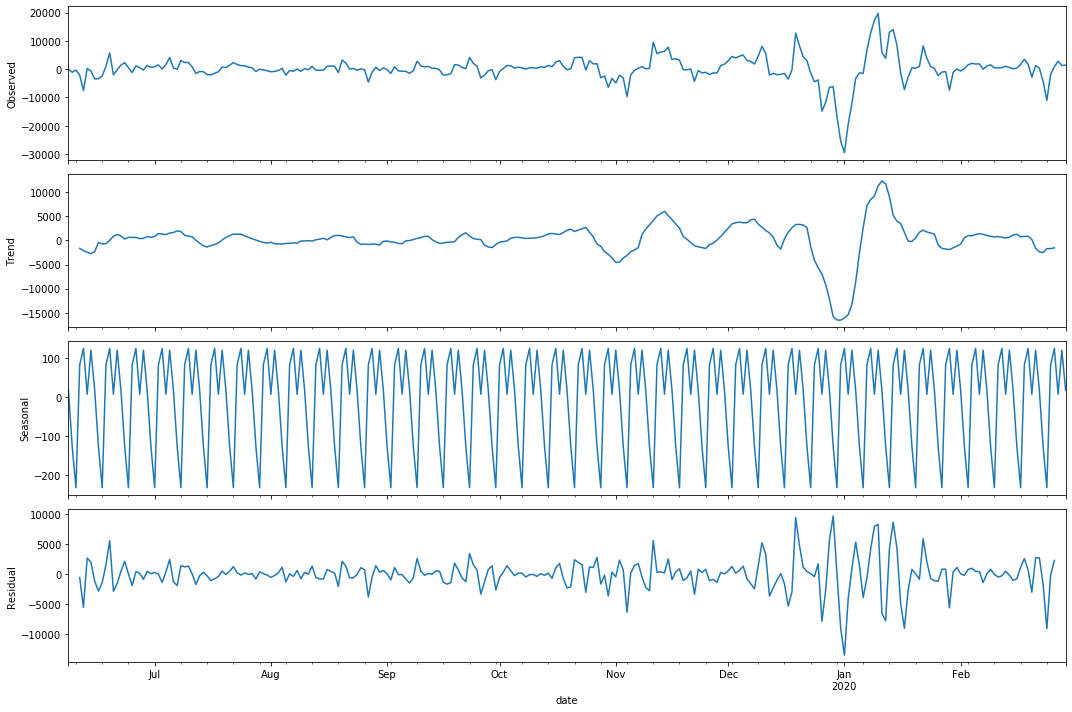

In [13]:
train['transactions_diff'] = train.transactions - train.transactions.shift(7) 
plt.figure(figsize(15,10))
g = sm.tsa.seasonal_decompose(train.transactions_diff[7:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train.transactions_diff[7:])[1])

Not bad.

Критерий Д-Ф опровергает гипотезу о нестационарности. Тренд в нуле. Остатки случайны. Все изъяны ряда вылечены, можно двигаться дальше. Пришло время посмотреть на коррелограмму (это такой график зависимости текущего значения от предыдущих лагов)

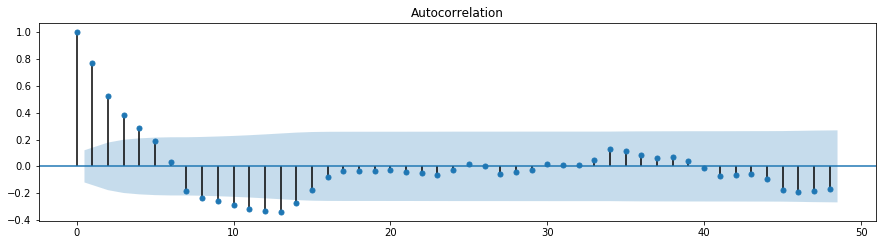

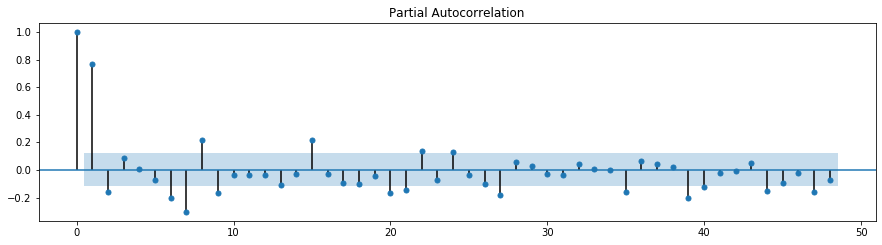

In [14]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train.transactions_diff[7:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train.transactions_diff[7:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [17]:
ps = range(0, 7)
d=1
qs = range(0, 7)
Ps = range(0, 7)
D=0
Qs = range(0, 7)

In [18]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

2401

In [21]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train.transactions, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

KeyboardInterrupt: 

In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
827  (2, 2, 6, 1)  5255.723235
830  (2, 2, 6, 4)  5256.067093
829  (2, 2, 6, 3)  5256.921182
831  (2, 2, 6, 5)  5258.426380
832  (2, 2, 6, 6)  5261.365718
